### 学习向量量化

学习向量量化(*Learning Vector Quantization*,简称 $LVQ$)与 $k-means$ 类似，试图找到一组原型向量来刻画聚类结构，不同的是，$LVQ$ 假设数据样本带有类别标记，学习过程需要利用样本的这些监督信息来辅助聚类。

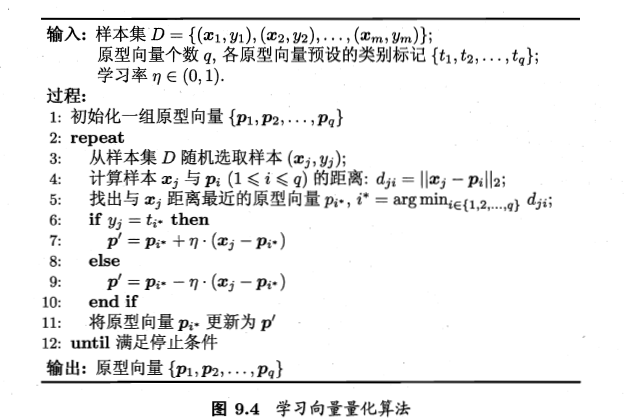

停止条件可以是达到最大迭代次数，或原型向量更新很小甚至不再更新。返回的原型向量 $\{p_1,p_2,...,p_q\}$ 可以实现对样本空间的簇划分。对任意样本 $x$ ，它将被划分到与其距离最近的原型向量所代表的簇中。 

### Code --- LVQ

In [246]:
# 导包

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# 对中文的支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [247]:
# 加载数据 西瓜数据集4.0

df = pd.read_csv('data4.0.csv')
df

,编号,密度,含糖率
0,1,0.697,0.460
1,2,0.774,0.376
2,3,0.634,0.264
3,4,0.608,0.318
4,5,0.556,0.215
5,6,0.403,0.237
6,7,0.481,0.149
7,8,0.437,0.211
8,9,0.666,0.091
9,10,0.243,0.267


In [248]:
dt = df.iloc[:, 1:].to_numpy()

# 添加标签 10 表示好瓜=是，5 表示好瓜=否,为了作图美观，没有选择{0,1} 划分
label = np.ones((30, 1)) * 10
label[8:21, -1] = 5

In [402]:
# LVQ 算法


def LVQdemo(x, y, q, lr, expoch):
    """
    x:训练样本特征向量
    y:样本标签
    q:原型向量个数
    lr:学习率
    return:返回原型向量{p1,p2,...,pq}
    """
    cp_x = np.copy(x)
    cp_y = np.copy(y)
    m = len(cp_y)

    import random
    # 初始化一组原型向量 {p1,p2,...,pq}
    #     p = cp_x[[4,11,17,22,28],:]
    #     py = cp_y[[4,11,17,22,28],:]

    arg = random.sample(range(0, m), q)
    p = cp_x[arg, :]
    py = cp_y[arg, :]

    C = {}
    # 初始化 C
    for n in range(q):
        C[str(n)] = set()

    for step in range(1, expoch + 1):
        # 从样本集 D 随机选取样本 (xj,yj)
        j = random.sample(range(0, m), 1)
        xj = cp_x[j, :]
        yj = cp_y[j]
        #         xj = cp_x[0]
        #         yj = cp_y[0]
        # 计算样本 xj 与 pi 的距离
        dist = np.sqrt(np.sum((xj - p)**2, axis=1))

        # 找出距离 xj 最近的原型向量 pi,下标 i
        min_dist = np.min(dist)
        i = np.argmin(dist)
        old_p = np.copy(p)
        if yj == py[i]:
            tp = p[i] + lr * (xj - p[i])
            C[str(i)].add(j[0])
        else:
            tp = p[i] - lr * (xj - p[i])

        p[i] = tp

        if step % 50 == 0 or step == 1:
            arg1 = np.where(cp_y == 10)[0]
            arg2 = np.where(cp_y == 5)[0]
            x1 = cp_x[arg1]
            y1 = cp_y[arg1]
            x2 = cp_x[arg2]
            y2 = cp_y[arg2]

            plt.figure()
            plt.scatter(x1[:, 0], x1[:, 1], s=y1 * 10, alpha=0.5, c='r')
            plt.scatter(x2[:, 0], x2[:, 1], s=y2 * 10, alpha=0.5, c='g')
            plt.scatter(p[:, 0],
                        p[:, 1],
                        s=py * 10,
                        alpha=0.9,
                        c='b',
                        marker='x')
            plt.title("第%d次迭代" % (step))
            plt.xlabel('密度')
            plt.ylabel('含糖率')
            print("step:%d\n,p:" % (step), p)

#         if np.sum((np.abs(old_p-p)<1e-9)+0)==p.size:
#             break

    return p


# 根据 p 划分簇
def sliceData(D, p):
    new_D = np.copy(D)
    m = len(new_D)

    C = {}
    # 初始化 C
    for n in range(len(p)):
        C[str(n)] = set()

    for j in range(m):
        # 计算样本 xj 与各均值向量 miu 的距离：dist_ji
        x_j = np.tile(new_D[j], (len(p), 1))
        dist = np.sqrt(np.sum((x_j - p)**2, axis=1))
        # 根据距离最近的均值向量确定 xj 的簇标记
        min_dist = np.min(dist)
        argmin = np.argmin(dist)
        C[str(argmin)].add(j)
    c = ['c', 'b', 'g', 'r', 'm', 'y', 'k', 'w']
    for i in range(len(p)):
        x1 = new_D[list(C[str(i)]), 0]
        x2 = new_D[list(C[str(i)]), 1]
        plt.scatter(x1, x2, alpha=0.5, c=c[i])
        plt.xlabel('密度')
        plt.ylabel('含糖率')
        plt.scatter(p[i, 0], p[i, 1], s=100, alpha=0.9, c=c[i], marker='x')
    return C

step:1
,p: [[0.339 0.241]
 [0.473 0.376]
 [0.556 0.215]
 [0.748 0.232]
 [0.725 0.445]]
step:50
,p: [[0.30370996 0.18332655]
 [0.49418822 0.42268567]
 [0.5247121  0.21689904]
 [0.68841602 0.12276933]
 [0.72612998 0.4394985 ]]
step:100
,p: [[0.27894734 0.19180503]
 [0.50277667 0.42927243]
 [0.4998725  0.22593552]
 [0.66780512 0.13056721]
 [0.73460182 0.43162821]]
step:150
,p: [[0.2976406  0.21399653]
 [0.5117208  0.43204361]
 [0.46236752 0.21899456]
 [0.66199534 0.1154873 ]
 [0.74258301 0.44397583]]
step:200
,p: [[0.31797012 0.19210846]
 [0.51800425 0.36948807]
 [0.45696732 0.20696926]
 [0.68822088 0.13285478]
 [0.73896518 0.46370394]]


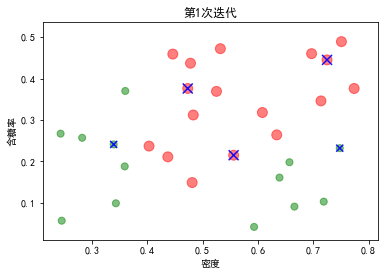

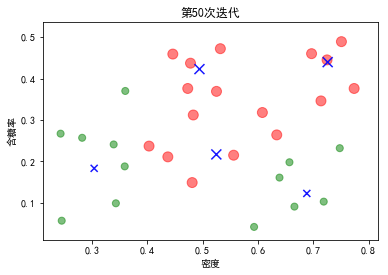

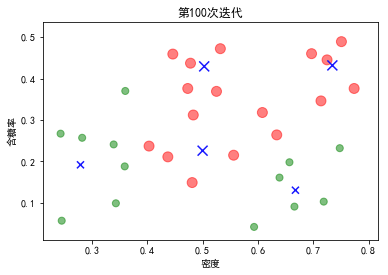

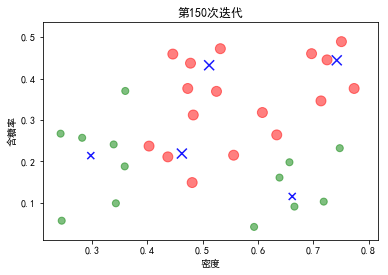

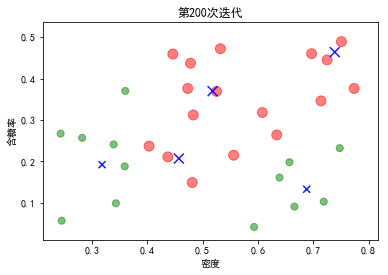

In [403]:
p = LVQdemo(x=dt,y=label,lr=0.2,q=5,expoch=200)

({'0': {9, 10, 11, 17, 18, 19},
  '1': {3, 14, 22, 23, 24, 26, 27, 29},
  '2': {4, 5, 6, 7},
  '3': {2, 8, 12, 13, 15, 16, 20},
  '4': {0, 1, 21, 25, 28}},
 '',
 array([[0.31797012, 0.19210846],
        [0.51800425, 0.36948807],
        [0.45696732, 0.20696926],
        [0.68822088, 0.13285478],
        [0.73896518, 0.46370394]]))

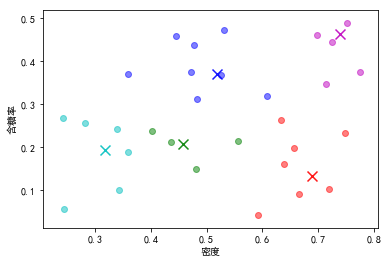

In [404]:
c = sliceData(dt,p)
c,'',p